# Generic HMC 

### Imports

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import Gaussian, GMM, gen_ring
from utils.jacobian import _map, jacobian

from HMC.hmc import HMC

from lattice.gauge_lattice import GaugeLattice, pbc, mat_adj, u1_plaq_exact

%autoreload 2

tf.enable_eager_execution()
tfe = tf.contrib.eager

Using TensorFlow backend.


## 2D $U(1)$ Lattice Gauge Theory

In [15]:
time_size, space_size, dim, beta, num_samples = (8, 8, 2, 3., None)
link_type = 'U1'
lattice = GaugeLattice(time_size=time_size,
                       space_size=space_size,
                       dim=dim,
                       beta=beta,
                       link_type=link_type,
                       num_samples=num_samples, rand=True)
#samples = np.array([sample.flatten() for sample in lattice.samples])
lattice_energy_fn = lattice.get_energy_function()

In [16]:
step_size = 0.05
n_leapfrog_steps = 10
#position_init = samples
position_init = lattice.links_flat
lattice_hmc = HMC(position_init=position_init,
                  step_size=step_size,
                  n_leapfrog_steps=n_leapfrog_steps,
                  potential_fn=lattice_energy_fn,
                  beta=lattice.beta)

In [17]:
momentum0 = np.random.randn(*lattice.links_flat.shape)
links0 = lattice.links_flat
#momentum0 = np.random.randn(*position_init.shape)
links0 = position_init
links_arr = [links0]
vel_arr = []
probs_arr = []
avg_plaq_arr = [lattice._average_plaquette(links0)]
total_action_arr = [lattice._total_action(links0)]
links1 = links0
num_steps = 500
for i in range(num_steps):
    links1, vel1, probs1 = lattice_hmc.apply_transition(links1)
    total_action = lattice._total_action(links1)
    avg_plaq = lattice._average_plaquette(links1)
    print(f'step: {i:<5g} accept rate: {np.mean(probs1):^8.5g}  '
          f'average_plaquette: {avg_plaq:^8.5g}  '
          f'total action: {total_action:^8.5g}  '
          f'change: {avg_plaq - avg_plaq_arr[i-1]:^8.5g}')
    avg_plaq_arr.append(avg_plaq)
    total_action_arr.append(total_action)
    if i % 50 == 0:
        links_arr.append(links1)
        vel_arr.append(vel1)
        probs_arr.append(probs1)
    if i % (num_steps // 10):
        lattice_hmc.step_size *= 0.98

step: 0     accept rate:    1      average_plaquette:  0.5095   total action:  94.176   change:  0.5934 
step: 1     accept rate:    1      average_plaquette: 0.67886   total action:  61.659   change: 0.76276 
step: 2     accept rate:    1      average_plaquette: 0.74462   total action:  49.033   change: 0.23512 
step: 3     accept rate:    1      average_plaquette: 0.82394   total action:  33.804   change: 0.14508 
step: 4     accept rate: 0.94664   average_plaquette: 0.78084   total action:  42.079   change: 0.036216
step: 5     accept rate:    1      average_plaquette: 0.79822   total action:  38.741   change: -0.025716
step: 6     accept rate: 0.91338   average_plaquette: 0.74676   total action:  48.622   change: -0.034077
step: 7     accept rate:    1      average_plaquette: 0.76416   total action:  45.281   change: -0.034064
step: 8     accept rate: 0.96401   average_plaquette: 0.74862   total action:  48.265   change: 0.0018613
step: 9     accept rate:    1      average_plaquett

step: 78    accept rate:    1      average_plaquette: 0.85397   total action:  28.039   change: 0.039683
step: 79    accept rate: 0.99974   average_plaquette: 0.85655   total action:  27.543   change: 0.02598 
step: 80    accept rate:    1      average_plaquette: 0.85667   total action:  27.52    change: 0.0027011
step: 81    accept rate: 0.99893   average_plaquette:  0.8511   total action:  28.588   change: -0.0054435
step: 82    accept rate:    1      average_plaquette: 0.85893   total action:  27.086   change: 0.0022611
step: 83    accept rate:    1      average_plaquette: 0.85084   total action:  28.638   change: -0.0002591
step: 84    accept rate:    1      average_plaquette: 0.85297   total action:  28.229   change: -0.0059552
step: 85    accept rate:    1      average_plaquette: 0.86572   total action:  25.782   change: 0.014874
step: 86    accept rate: 0.99981   average_plaquette: 0.85693   total action:  27.47    change: 0.0039549
step: 87    accept rate: 0.99908   average_pla

step: 156   accept rate: 0.99998   average_plaquette: 0.84442   total action:  29.872   change: 0.0079556
step: 157   accept rate: 0.99999   average_plaquette: 0.84201   total action:  30.335   change: -0.0023815
step: 158   accept rate:    1      average_plaquette: 0.84024   total action:  30.675   change: -0.0041808
step: 159   accept rate:    1      average_plaquette: 0.83968   total action:  30.781   change: -0.0023213
step: 160   accept rate:    1      average_plaquette: 0.84065   total action:  30.595   change: 0.00041801
step: 161   accept rate: 0.99999   average_plaquette: 0.83899   total action:  30.914   change: -0.00069523
step: 162   accept rate:    1      average_plaquette:  0.838    total action:  31.103   change: -0.0026501
step: 163   accept rate: 0.99998   average_plaquette:  0.8355   total action:  31.585   change: -0.0034934
step: 164   accept rate:    1      average_plaquette:  0.8378   total action:  31.143   change: -0.00020486
step: 165   accept rate: 0.99998   a

step: 233   accept rate:    1      average_plaquette: 0.83759   total action:  31.182   change: -0.00011688
step: 234   accept rate:    1      average_plaquette: 0.83762   total action:  31.177   change: -0.00037354
step: 235   accept rate: 0.99997   average_plaquette: 0.83751   total action:  31.198   change: -8.2493e-05
step: 236   accept rate:    1      average_plaquette: 0.83796   total action:  31.113   change: 0.00033486
step: 237   accept rate: 0.99998   average_plaquette: 0.83809   total action:  31.087   change: 0.00057483
step: 238   accept rate: 0.99999   average_plaquette: 0.83779   total action:  31.143   change: -0.00016087
step: 239   accept rate:    1      average_plaquette: 0.83911   total action:  30.89    change: 0.0010271
step: 240   accept rate:    1      average_plaquette: 0.83818   total action:  31.069   change: 0.00038683
step: 241   accept rate: 0.99998   average_plaquette: 0.83876   total action:  30.958   change: -0.00035298
step: 242   accept rate:    1    

step: 310   accept rate: 0.99998   average_plaquette:  0.8399   total action:  30.74    change: -0.00025272
step: 311   accept rate: 0.99999   average_plaquette: 0.84018   total action:  30.684   change: 0.00034642
step: 312   accept rate: 0.99999   average_plaquette: 0.84011   total action:  30.699   change: 0.00021052
step: 313   accept rate:    1      average_plaquette: 0.84033   total action:  30.657   change: 0.00014532
step: 314   accept rate: 0.99999   average_plaquette:  0.8405   total action:  30.625   change: 0.00038868
step: 315   accept rate:    1      average_plaquette: 0.84048   total action:  30.627   change: 0.00015301
step: 316   accept rate: 0.99997   average_plaquette: 0.84049   total action:  30.627   change: -9.5963e-06
step: 317   accept rate: 0.99999   average_plaquette: 0.84048   total action:  30.627   change: 1.6689e-06
step: 318   accept rate:    1      average_plaquette:  0.8405   total action:  30.624   change: 1.5676e-05
step: 319   accept rate: 0.99999   

step: 387   accept rate: 0.99999   average_plaquette: 0.84071   total action:  30.583   change: -8.1062e-06
step: 388   accept rate: 0.99996   average_plaquette: 0.84075   total action:  30.577   change: 3.6299e-05
step: 389   accept rate:    1      average_plaquette: 0.84076   total action:  30.575   change: 4.5478e-05
step: 390   accept rate:    1      average_plaquette: 0.84076   total action:  30.575   change: 1.0371e-05
step: 391   accept rate:    1      average_plaquette: 0.84074   total action:  30.578   change: -1.7345e-05
step: 392   accept rate:    1      average_plaquette: 0.84075   total action:  30.575   change: -2.6822e-06
step: 393   accept rate:    1      average_plaquette: 0.84072   total action:  30.581   change: -1.5318e-05
step: 394   accept rate: 0.99995   average_plaquette: 0.84076   total action:  30.573   change: 1.0669e-05
step: 395   accept rate: 0.99999   average_plaquette: 0.84082   total action:  30.563   change: 9.2745e-05
step: 396   accept rate: 0.99998 

step: 464   accept rate: 0.99999   average_plaquette: 0.84088   total action:  30.551   change: -1.1683e-05
step: 465   accept rate: 0.99995   average_plaquette: 0.84089   total action:  30.55    change: 8.3447e-07
step: 466   accept rate:    1      average_plaquette: 0.84088   total action:  30.551   change: -2.3246e-06
step: 467   accept rate: 0.99999   average_plaquette: 0.84088   total action:  30.551   change: -6.3777e-06
step: 468   accept rate: 0.99998   average_plaquette: 0.84088   total action:  30.55    change: 5.7817e-06
step: 469   accept rate: 0.99995   average_plaquette: 0.84088   total action:  30.55    change: 5.2452e-06
step: 470   accept rate: 0.99998   average_plaquette: 0.84089   total action:  30.549   change: 9.5367e-06
step: 471   accept rate:    1      average_plaquette:  0.8409   total action:  30.547   change: 1.4901e-05
step: 472   accept rate:    1      average_plaquette: 0.84089   total action:  30.549   change: -8.3447e-07
step: 473   accept rate:    1    

In [106]:
np.mean(avg_plaq_arr)

0.8173924

In [107]:
avg_plaquettes = [lattice._average_plaquette(config) for config in links_arr]

In [111]:
np.mean(avg_plaquettes)

0.8431919

In [110]:
u1_plaq_exact(beta)

0.8099852939565045

## Strongly Correlated Gaussian target distribution (for testing HMC implementation)

### Define log density function of target distribution (potential energy function) $S(x)$

$$ S(\mathbf{x}) = \frac{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})}{\sqrt{|\Sigma|}} $$ 


In [16]:
mu = np.zeros(2)
cov = np.array([[1., 0.95], [0.95, 1.]], dtype=np.float32)
cov_inv = np.linalg.inv(np.copy(cov))
def quadratic_gaussian(x):
    x_mu = x - mu
    return 0.5 * tf.reduce_sum(tf.transpose(x_mu) * cov_inv * x_mu)

def quadratic_gaussian_grad(x):
    return x

### Exact target distribution

In [18]:
mean = [0, 0]
cov = [[1., 0.95], [0.95, 1.]]
samples_x, samples_y = np.random.multivariate_normal(mean, cov, 1000).T

### Instantiate HMC object for sampling

In [19]:
step_size = 0.1
n_leapfrog_steps = 15
hmc = HMC(position_init=np.random.randn(2), 
          step_size=step_size,
          n_leapfrog_steps=n_leapfrog_steps,
          potential_fn=quadratic_gaussian,
          grad_potential_fn=grad_quad_gaussian)
          #grad_potential_fn=grad_quad_gaussian)

In [11]:
pos0 = [[-1., 1.]]
pos = [pos0]
vel = []
probs = []
pos1 = pos0

for i in range(500):
    #pos0 = pos[i-1]
    pos1, vel1, probs1 = hmc.apply_transition(pos1)
    pos.append(pos1)
    vel.append(vel1)
    probs.append(probs1)
pos = np.array(pos).reshape(len(pos), -1)
vel = np.array(vel)
probs = np.array(probs)

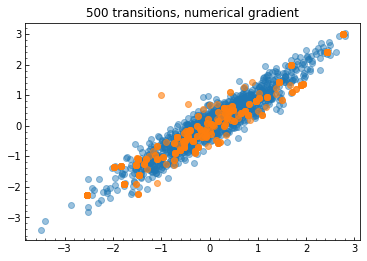

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()

### Look at the leapfrog integrator to tune hyperparameters

In [12]:
x0 = np.array([-1., 1.])
p0 = np.random.randn(*np.array(x0).shape)
x, p = x0, p0
x_arr = []
p_arr = []
for i in range(n_leapfrog_steps):
    lf_out = hmc._leapfrog_fn(x, p, i)
    x, p = lf_out
    x_arr.append(x)
    p_arr.append(p)
x_arr = np.array(x_arr)
p_arr = np.array(p_arr)

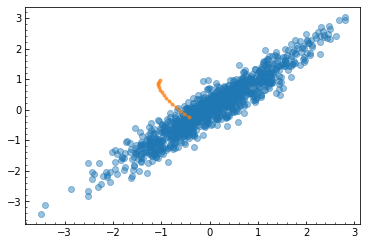

In [14]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(x_arr[:,0], x_arr[:,1], marker='.', ls='-', alpha=0.6)
plt.show()

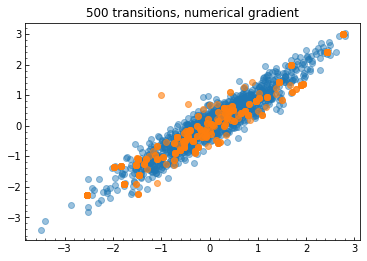

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()